# Introduction

This Jupyter Notebook contains the final realization of a school project related to Natural Language Processing (NLP). More specifically, a Transformer-based architecture was utilized to classify text as normal, offensive, or hateful, using comments from 4chan's /pol/ board as data to classify. 

As this Notebook contains the final code necessary to properly utilize the chosen model and classify textual input, any steps related to preparation, cleaning, or the gathering of data are omitted. Comments are provided wherever necessary, but how each component of the Transformer model functions is not expanded upon in this document.

All NLP-specific imports, the model used, the docs consulted, and the courses followed originate from Hugging Face 🤗 (https://huggingface.co/).

# Imports

In [1]:
# General-purpose imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
from datetime import datetime
from sklearn.model_selection import train_test_split

In [2]:
# NLP-specific imports
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import list_metrics, load_metric
import torch

In [3]:
# Loading of the t-davidson and /pol/ datasets
tdavidson = pd.read_csv('data/tdavidson_prepared.csv', index_col = [0])
pol = pd.read_csv('data/pol_prepared.csv')

In [4]:
# Loading of metrics for model evaluation
metric_acc = load_metric('accuracy')
metric_f1 = load_metric('f1')
metric_auc = load_metric('roc_auc', "multiclass")

# Implementation

### Untrained Model

In [5]:
# Loading of the HateXplain Transformer model and its tokenizer
checkpoint = "Hate-speech-CNERG/bert-base-uncased-hatexplain"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [6]:
# Confirmation of the model's labels
model.config.id2label

{0: 'hate speech', 1: 'normal', 2: 'offensive'}

In [7]:
# Splitting of the t-davidson data into training, testing, and validation sets, according to a 60:20:20 split
# The sequences and labels are separated into different variables
train_texts, test_texts, train_labels, test_labels = train_test_split(tdavidson['comment'], 
                                                                      tdavidson['label'], 
                                                                      test_size=0.2,
                                                                      stratify=tdavidson['label'])

train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, 
                                                                    train_labels, 
                                                                    test_size=0.25, 
                                                                    stratify=train_labels)

In [8]:
# As Transformer models are very heavy on memory, only 250 sequences are evaluated at a time
testcomments = test_texts.tolist()[:250]
testlabels = test_labels.tolist()[:250]

In [9]:
# Implementation of the pre-trained model, without any improvements
tokens = tokenizer(testcomments, padding=True, truncation=True, return_tensors="pt")
output = model(**tokens)
predictions = torch.nn.functional.softmax(output.logits, dim=-1)
modelresults = pd.DataFrame(predictions.detach().numpy() * 100, columns = ['hate_speech','normal','offensive'])
modelresults

,hate_speech,normal,offensive
0,3.750997,53.927589,42.321411
1,4.571366,40.656158,54.772480
2,7.454917,29.999557,62.545521
3,4.431598,55.128223,40.440174
4,12.026351,56.208824,31.764824
...,...,...,...
245,5.042333,36.044281,58.913387
246,3.357765,15.919551,80.722687
247,5.598469,31.564983,62.836552
248,4.888644,55.005531,40.105824


In [10]:
# Creation of a new column that contains, for each row, the column name which had the highest percentage value
modelresults['label'] = modelresults.idxmax(axis=1)

In [11]:
# Transformation of the new column's label contents to their related numerical values
modelresults.loc[modelresults['label'] == 'hate_speech', 'label'] = 0
modelresults.loc[modelresults['label'] == 'normal', 'label'] = 1
modelresults.loc[modelresults['label'] == 'offensive', 'label'] = 2

In [12]:
# Usage of the previously-loaded metrics to evaluate the model
print(metric_acc.compute(predictions = modelresults['label'], references = testlabels))
print(metric_f1.compute(predictions = modelresults['label'], references = testlabels, average="macro"))
print(metric_auc.compute(prediction_scores = predictions, references = testlabels, multi_class='ovr'))

{'accuracy': 0.644}
{'f1': 0.5175662404909244}
{'roc_auc': 0.8437027269244548}


In [13]:
# Deletion of the model-related variables to free up memory
del tokens, output, predictions, modelresults

### Fine-tuning Process

In [14]:
# Creation of encoding through tokenization for the creation of a Dataset object
train_encodings = tokenizer(train_texts.tolist(), truncation = True, padding = True)
val_encodings = tokenizer(val_texts.tolist(), truncation = True, padding = True)
test_encodings = tokenizer(test_texts.tolist(), truncation = True, padding = True)

In [15]:
# Usage of PyTorch to create a Dataset object to be used for the fine-tuning process of the model
# Encoding and their related labels that were previously separated are again unified
class TFDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TFDataset(train_encodings, train_labels.tolist())
val_dataset = TFDataset(val_encodings, val_labels.tolist())
test_dataset = TFDataset(test_encodings, test_labels.tolist())

In [ ]:
### Don't randomly run this code! ###

# Training process of the model, using the training and validation datasets
# The process is very lengthy and may take several hours to complete
training_args = TrainingArguments(
    output_dir = './results',              # output directory
    num_train_epochs = 3,                  # total number of training epochs
    per_device_train_batch_size = 16,      # batch size per device during training
    per_device_eval_batch_size = 64,       # batch size for evaluation
    warmup_steps = 500,                    # number of warmup steps for learning rate scheduler
    weight_decay = 0.01,                   # strength of weight decay
    logging_dir = './logs',                # directory for storing logs
    logging_steps = 10,
)

trainer = Trainer(
    model = model,                         # the instantiated 🤗 Transformers model to be trained
    args = training_args,                  # training arguments, defined above
    train_dataset = train_dataset,         # training dataset
    eval_dataset = val_dataset             # evaluation dataset
)

trainer.train()

In [ ]:
### Don't randomly run this code! ###

# Saving of the trained model in the results folder to not waste any work
trainer.save_model('./results')

### Trained Model

In [16]:
# Loading of the improved HateXplain Transformer model from the results folder
trainedmodel = AutoModelForSequenceClassification.from_pretrained('./results')

In [17]:
# Reconfirmation of the model's labels
model.config.id2label

{0: 'hate speech', 1: 'normal', 2: 'offensive'}

In [18]:
# Implementation of the improved model
trainedtokens = tokenizer(testcomments, padding=True, truncation=True, return_tensors="pt")
trainedoutput = trainedmodel(**trainedtokens)
trainedpredictions = torch.nn.functional.softmax(trainedoutput.logits, dim=-1)
trainedmodelresults = pd.DataFrame(trainedpredictions.detach().numpy() * 100, columns = ['hate_speech','normal','offensive'])
trainedmodelresults

,hate_speech,normal,offensive
0,0.112522,0.062075,99.825401
1,0.326631,0.196668,99.476707
2,1.077055,0.057592,98.865356
3,0.299764,0.017790,99.682449
4,0.152730,99.659882,0.187388
...,...,...,...
245,0.209567,0.031009,99.759415
246,0.299153,0.071754,99.629089
247,0.168858,0.030870,99.800270
248,0.184320,0.029268,99.786415


In [19]:
# Creation of a new column that contains, for each row, the column name which had the highest percentage value
trainedmodelresults['label'] = trainedmodelresults.idxmax(axis=1)

In [20]:
# Transformation of the new column's label contents to their related numerical values
trainedmodelresults.loc[trainedmodelresults['label'] == 'hate_speech', 'label'] = 0
trainedmodelresults.loc[trainedmodelresults['label'] == 'normal', 'label'] = 1
trainedmodelresults.loc[trainedmodelresults['label'] == 'offensive', 'label'] = 2

In [21]:
# Usage of the previously-loaded metrics to evaluate the model
print(metric_acc.compute(predictions = trainedmodelresults['label'], references = testlabels))
print(metric_f1.compute(predictions = trainedmodelresults['label'], references = testlabels, average="macro"))
print(metric_auc.compute(prediction_scores = trainedpredictions, references = testlabels, multi_class='ovr'))

{'accuracy': 0.968}
{'f1': 0.9382628938968488}
{'roc_auc': 0.9824880601815332}


In [22]:
# Deletion of the model-related variables to free up memory
del trainedtokens, trainedoutput, trainedpredictions, trainedmodelresults

### Interjection

At this point, both the pre-trained model and its improved version have been tried and tested on the same testing data. The original model with no augmentations performed poorly. The metrics indicated a low accuracy, and from observing the results DataFrame it was visible that the percentage values behind the choices weren't very high either. This means that slight deviations in input could easily tilt the resulting labels in another direction, making the model untrustworthy.

The improved version of the model boasts high scores with the metrics, and it's also very decisive when making a labelling choice. In comparison, the original and the improved versions are like night and day, making the improved version a succesful and trustworthy candidate for the labelling of the /pol/ data.

### Labelling /pol/ Data

In [ ]:
### Don't randomly run this code! ###

# As labelling 250 sequences is already very costly in terms of memory, labelling ~450K sequences is unfeasible
# This loop takes batches of 100 sequences every iteration and saves them in a CSV file for later usage
# Memory is freed up between each iteration
# The process is very lengthy and may take a full day to complete
loops = math.ceil(pol.shape[0] / 100)
for i in range(loops):
    start = i * 100
    batch = pol[start: start + 100]
    
    tokens = tokenizer(batch['comment'].tolist(), padding=True, truncation=True, return_tensors="pt")
    output = trainedmodel(**tokens)
    predictions = torch.nn.functional.softmax(output.logits, dim = -1)
    modelresults = pd.DataFrame(predictions.detach().numpy() * 100, columns = ['hate_speech','normal','offensive'])

    modelresults['label'] = modelresults.idxmax(axis=1)
    modelresults.loc[modelresults['label'] == 'hate_speech', 'label'] = 0
    modelresults.loc[modelresults['label'] == 'normal', 'label'] = 1
    modelresults.loc[modelresults['label'] == 'offensive', 'label'] = 2
    modelresults['post_number'] = pol['post_number'][start: start + 100].tolist()

    modelresults.to_csv('pol_labels.csv', mode = 'a', index = False, header = False)

    del batch, tokens, output, predictions, modelresults
    
    sys.stdout.write(f"\r loop:{i + 1}/{loops}")
    sys.stdout.flush()

In [23]:
# Loading of the /pol/ labels that were saved in a CSV file
pollabels = pd.read_csv("data/pol_labels.csv")

In [24]:
# Confirming that both datasets have the same shape and that no data is missing
print(pol.shape[0])
print(pollabels.shape[0])

455503
455503


In [25]:
# Merging of the /pol/ dataset and the corresponding labels, based on a common column containing unique post numbers
polmerged = pd.merge(pol, pollabels, on='post_number', how='left')

In [ ]:
### Don't randomly run this code! ###

# Saving of the merged data for later usage
polmerged.to_csv('data/pol_final.csv', index=False)

# Short Exploration

A short exploration of the labelled /pol/ dataset to show volume of speech per country, and per label. A more detailed exploration is done through the creation of a PowerBI dashboard, not supplied in this repository.

In [26]:
# Loading of the labelled /pol/ dataset
polfinal = pd.read_csv('data/pol_final.csv')

In [27]:
polfinal.head()

,post_number,thread_number,timestamp,country,country_name,comment,reply_count,hate_speech,normal,offensive,label
0,379119380,0,2022-05-23 21:30:25,CA,Canada,"Casper, WYOMINGSat, May 28, 20224:00 pm MDT, 6...",199.0,0.154330,99.736800,0.108877,1
1,379119622,379119380,2022-05-23 21:32:03,US,United States,Attended by 10's of people,0.0,0.318119,98.489525,1.192354,1
2,379121108,379119380,2022-05-23 21:42:45,CA,Canada,Dumb shill.,0.0,0.276372,96.750050,2.973569,1
3,379121261,379119380,2022-05-23 21:43:52,HR,Croatia,"MAGA, thanks for baking",0.0,0.153533,99.307570,0.538890,1
4,379122427,379119380,2022-05-23 21:52:56,CA,Canada,Imagine wasting time making that.,0.0,1.027108,77.531075,21.441818,1


In [28]:
# Value counts of the volume of posts per country
polfinal['country_name'].value_counts()

United States     222684
Unknown            43700
United Kingdom     27172
Canada             27009
Australia          16334
                   ...  
Gibraltar              1
South Sudan            1
North Korea            1
Cayman Islands         1
Nicaragua              1
Name: country_name, Length: 156, dtype: int64

<AxesSubplot:ylabel='country_name'>

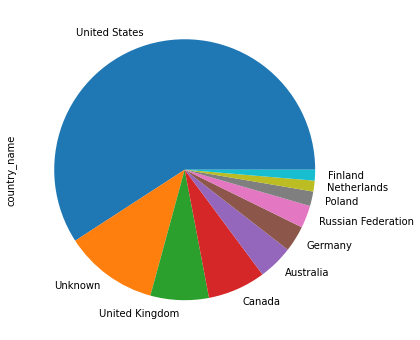

In [29]:
# Value counts of the volume of posts for the top 10 countries
polfinal['country_name'].value_counts()[:10].plot(kind='pie', figsize=(6,6))
plt.show()

In [30]:
# Percentage of message volume originating from the top 10 countries
polfinal['country_name'].value_counts()[:10].sum() / pol.shape[0]

0.8263721643984782

<AxesSubplot:ylabel='label'>

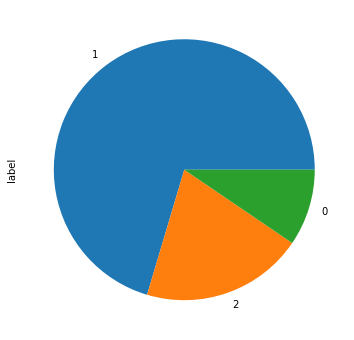

In [31]:
# Distribution of each speech type
polfinal['label'].value_counts().plot(kind='pie', figsize=(6,6))
plt.show()

In [32]:
# Reconfirmation of the model's labels
model.config.id2label

{0: 'hate speech', 1: 'normal', 2: 'offensive'}

In [33]:
# Percentage of messages that are either offensive or hateful
polfinal[polfinal['label'] != 1].shape[0] / polfinal.shape[0]

0.2960419580112535